In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from hyperopt import hp, fmin, rand
import collections
import statsmodels.api as sm

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [2]:
df = pd.read_csv("Sample_Washington.csv")
df

,neighbourhood,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,Historic Anacostia,Private room,55,2,74,2020-11-30,0.60,2,341,"Washington, D.C."
1,"Edgewood, Bloomingdale, Truxton Circle, Eckington",Private room,99,2,31,2016-09-22,0.25,3,173,"Washington, D.C."
2,"Kalorama Heights, Adams Morgan, Lanier Heights",Entire home/apt,74,3,95,2020-03-05,0.69,2,177,"Washington, D.C."
3,"Kalorama Heights, Adams Morgan, Lanier Heights",Private room,42,2,112,2019-10-30,0.82,2,0,"Washington, D.C."
4,"Dupont Circle, Connecticut Avenue/K Street",Entire home/apt,185,2,154,2020-10-05,1.18,2,1,"Washington, D.C."
...,...,...,...,...,...,...,...,...,...,...
4065,"Cathedral Heights, McLean Gardens, Glover Park",Entire home/apt,89,1,3,2020-12-11,3.00,3,161,"Washington, D.C."
4066,"Cleveland Park, Woodley Park, Massachusetts Av...",Entire home/apt,89,1,3,2020-12-11,3.00,3,0,"Washington, D.C."
4067,"Cathedral Heights, McLean Gardens, Glover Park",Entire home/apt,89,2,3,2020-12-11,3.00,3,174,"Washington, D.C."
4068,"Cathedral Heights, McLean Gardens, Glover Park",Entire home/apt,100,2,1,2020-12-20,1.00,3,334,"Washington, D.C."


In [3]:
df = df.drop(columns=['neighbourhood'])
df = df.drop(columns=['city'])
df = df.drop(columns=['last_review'])


<AxesSubplot:>

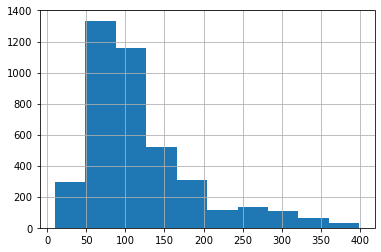

In [4]:
df.price.hist()

<AxesSubplot:>

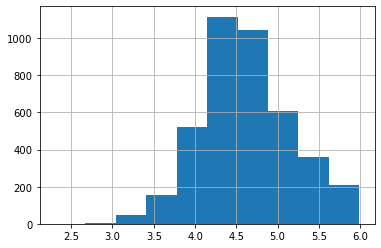

In [5]:
np.log(df.price).hist()

<AxesSubplot:>

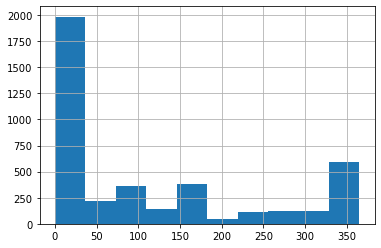

In [6]:
df.availability_365.hist()

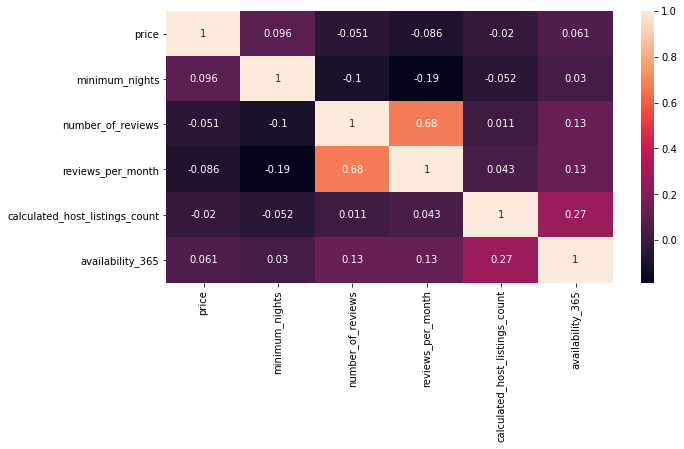

In [7]:
corrmat = df[df._get_numeric_data().columns].corr().round(7)
f, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(corrmat, annot=True)
plt.show()

In [8]:
df.price=np.log(df.price)

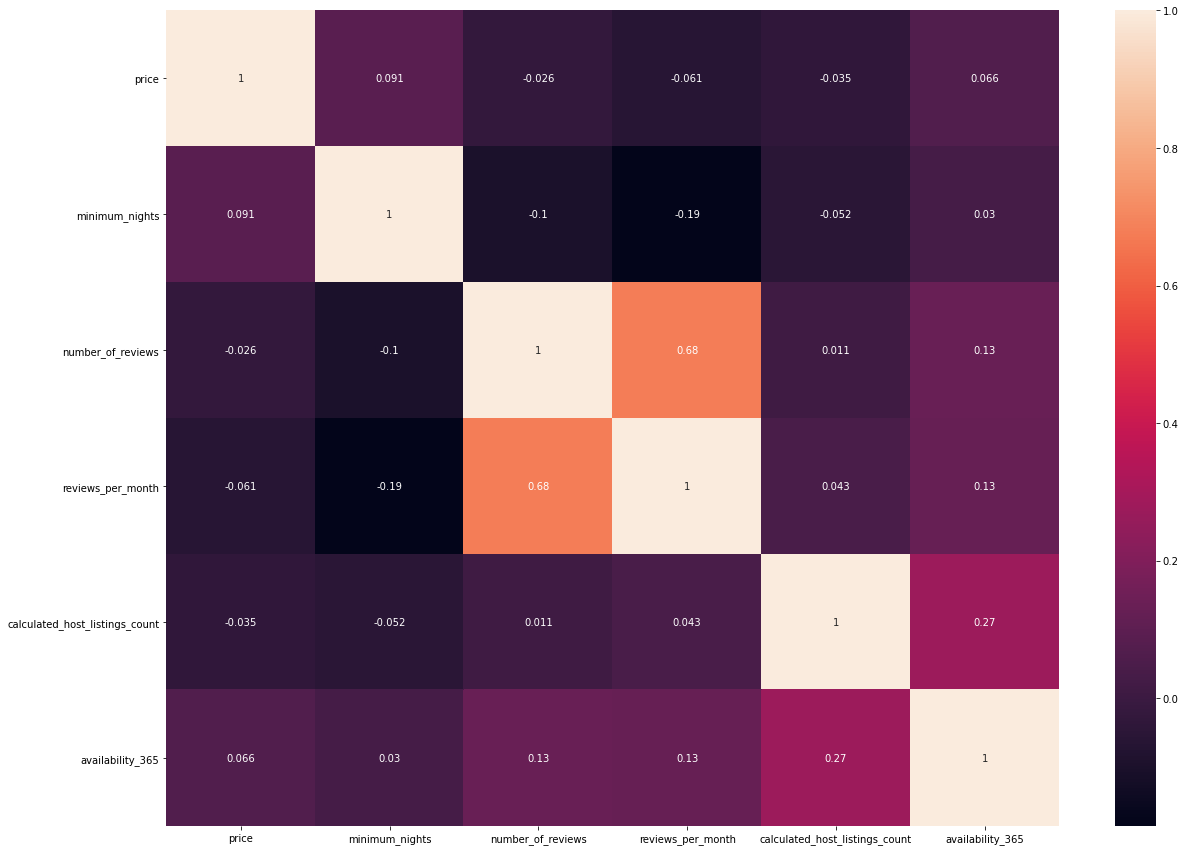

In [9]:
corrmat = df[df._get_numeric_data().columns].corr().round(7)
f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corrmat, annot=True)
plt.show()

In [10]:
def encoding_char(df):
    char_var = list(set(df.columns) - set(df._get_numeric_data().columns))
    for col_names in char_var:
        f = pd.factorize(df[col_names])
        df[col_names] = pd.factorize(df[col_names])[0]
    return(df)

df = encoding_char(df)
df.head()

,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,0,4.007333,2,74,0.60,2,341
1,0,4.595120,2,31,0.25,3,173
2,1,4.304065,3,95,0.69,2,177
3,0,3.737670,2,112,0.82,2,0
4,1,5.220356,2,154,1.18,2,1


In [11]:
train, test = train_test_split(df, test_size=0.2, random_state=0)
X_train = train.drop('price', axis=1)
X_test = test.drop('price', axis=1)
y_train = train.price
y_test = test.price

In [12]:
def metrics(X_train, X_test, y_train, y_test, y_pred, model):
    MSE = [mean_squared_error(np.exp(y_train), np.exp(model.predict(X_train))), mean_squared_error(np.exp(y_test), np.exp(y_pred))]
    RMSE = [np.sqrt(mean_squared_error(np.exp(y_train), np.exp(model.predict(X_train)))),np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred)))]
    R2 = [model.score(X_train, y_train), model.score(X_test, y_test)]
    results = {'MSE': MSE, 'RMSE': RMSE, 'R2':R2}
    return pd.DataFrame(results, index=['Train', 'Test'])

def visualising(X_train, X_test, y_train, y_test, y_pred, model):
    ### Training set ### 
    plt.scatter(X_train[['reviews_per_month']], np.exp(y_train), color = 'red')
    plt.plot(X_train[['reviews_per_month']], np.exp(model.predict(X_train)), 'bo')
    plt.title('Price vs Reviews per month (Training set) Washington D.C.')
    plt.xlabel('Reviews per month')
    plt.ylabel('Price')
    plt.show()
    
    ### Test set ### 
    plt.scatter(X_test[['reviews_per_month']], np.exp(y_test), color = 'red')
    plt.plot(X_test[['reviews_per_month']], np.exp(y_pred), 'bo')
    plt.title('Price vs Reviews per month (Test set) Washington D.C.')
    plt.xlabel('Reviews per month')
    plt.ylabel('Price')
    plt.show()


In [13]:
mr = LinearRegression().fit(X_train, y_train)
mr.coef_, mr.intercept_

(array([ 3.93318782e-01,  1.22388525e-02,  6.45725223e-04, -5.69692310e-02,
        -5.13005068e-03,  3.86360385e-04]),
 4.32113478217955)

In [14]:
mr_y_pred = mr.predict(X_test)
metrics(X_train, X_test, y_train, y_test, mr_y_pred, mr).round(2)
metric_lr = metrics(X_train, X_test, y_train, y_test, mr_y_pred, mr).round(2)
metric_lr["Type"] = "Linear regression"
metric_lr["city"] = "Washington, D.C."
metric_lr

,MSE,RMSE,R2,Type,city
Train,4784.76,69.17,0.13,Linear regression,"Washington, D.C."
Test,4777.81,69.12,0.17,Linear regression,"Washington, D.C."


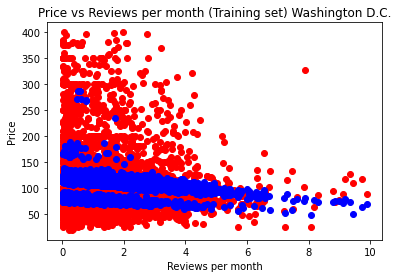

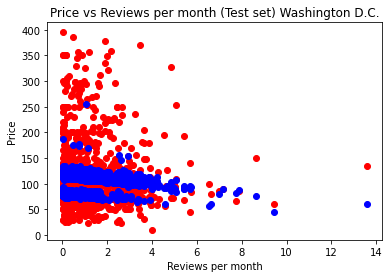

In [12]:
visualising(X_train, X_test, y_train, y_test, mr_y_pred, mr)

In [16]:
X = sm.add_constant(X_train)
mr1 = sm.OLS(y_train, X).fit()
#mr1.pvalues
mr1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     83.76
Date:                Tue, 09 Feb 2021   Prob (F-statistic):           8.09e-98
Time:                        11:05:27   Log-Likelihood:                -2397.0
No. Observations:                3256   AIC:                             4808.
Df Residuals:                    3249   BIC:                             4851.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              4.3211      0.026    165.369      0.000       4.270       4.372
room_type                          0.3933      0.019     20.799      0.000       0.356       0.430
minimum_nights                     0.0122      0.007      1.851      0.064      -0.001       0.025
number_of_reviews                  0.0006      0.000      2.462      0.014       0.000       0.001
reviews_per_month                 -0.0570      0.009     -6.600      0.000      -0.074      -0.040
calculated_host_listings_count    -0.0051      0.005     -1.132      0.258      -0.014       0.004
availability_365                   0.0004   7.05e-05      5.477      0.000       0.000       0.001
==============================================================================
Omnibus:                       30.454   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.970
Skew:                           0.095   Prob(JB):                     2.83e-10
Kurtosis:                       3.537   Cond. No.                         563.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
X_train_opt = X_train.drop(columns=["minimum_nights", "calculated_host_listings_count"])
X_test_opt = X_test.drop(columns=["minimum_nights", "calculated_host_listings_count"])
X_train_opt

,room_type,number_of_reviews,reviews_per_month,availability_365
1651,1,40,0.99,0
3803,1,15,2.74,77
2057,0,16,0.48,283
263,1,64,0.92,364
1763,1,107,2.70,8
...,...,...,...,...
835,1,4,0.08,0
3264,1,50,3.02,63
1653,0,10,0.24,82
2607,1,13,5.34,77


In [14]:
mr = LinearRegression().fit(X_train_opt, y_train)
mr.coef_, mr.intercept_

(array([ 3.98871200e-01,  6.75144176e-04, -6.02344318e-02,  3.73127658e-04]),
 4.338839405264472)

In [15]:
mr_y_pred = mr.predict(X_test_opt)
metrics(X_train_opt, X_test_opt, y_train, y_test, mr_y_pred, mr).round(2)

,MSE,RMSE,R2
Train,4803.73,69.31,0.13
Test,4797.74,69.27,0.17


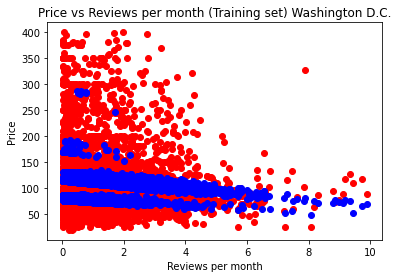

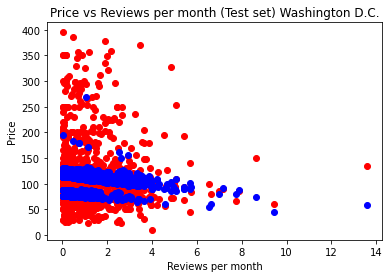

In [16]:
visualising(X_train_opt, X_test_opt, y_train, y_test, mr_y_pred, mr)

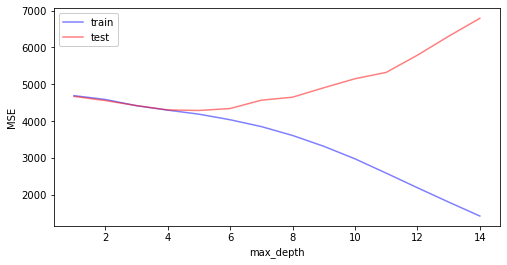

In [21]:
def max_depth(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        rf = DecisionTreeRegressor(max_depth = i, random_state=10).fit(X_train, y_train)
        mse_train.append(mean_squared_error(np.exp(y_train), np.exp(rf.predict(X_train))))
        mse_test.append(mean_squared_error(np.exp(y_test), np.exp(rf.predict(X_test))))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("max_depth")
    ax.legend(framealpha=1, frameon=True);

    
max_depth(X_train, X_test, y_train, y_test, list(range(1,15)))

In [15]:
dt = DecisionTreeRegressor(max_depth = 4, random_state=10).fit(X_train, y_train)
dt_y_pred = dt.predict(X_test)
metrics(X_train, X_test, y_train, y_test, dt_y_pred, dt).round(2)
metric_dt = metrics(X_train, X_test, y_train, y_test, dt_y_pred, dt).round(2)
metric_dt["Type"] = "Decision tree"
metric_dt["city"] = "Washington, D.C."
metric_dt

,MSE,RMSE,R2,Type,city
Train,4296.16,65.55,0.27,Decision tree,"Washington, D.C."
Test,4301.46,65.59,0.28,Decision tree,"Washington, D.C."


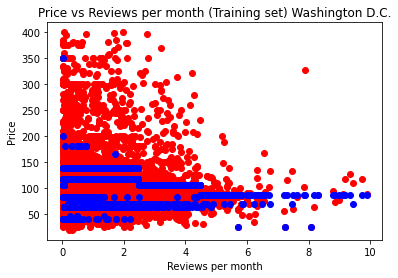

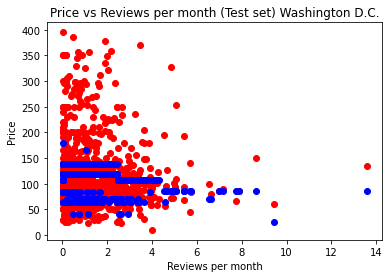

In [18]:
visualising(X_train, X_test, y_train, y_test, dt_y_pred, dt)

Text(0.5, 1.0, 'Decision Tree. Feature Importance. Washington D.C.')

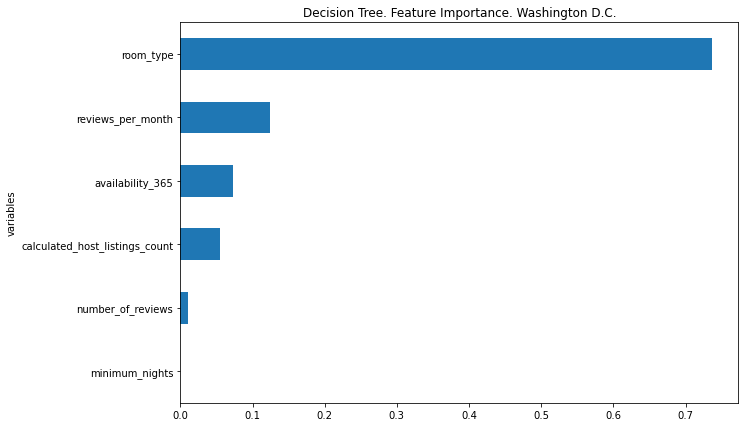

In [29]:
dt_imp = pd.DataFrame({'imp': dt.feature_importances_, 'variables': X_train.columns})
dt_imp = dt_imp.sort_values(['imp', 'variables'], ascending=[True, False]).iloc[-30:]
dt_imp.plot(kind='barh', x='variables', y='imp', figsize=(10, 7), legend=None)
plt.title('Decision Tree. Feature Importance. Washington D.C.')

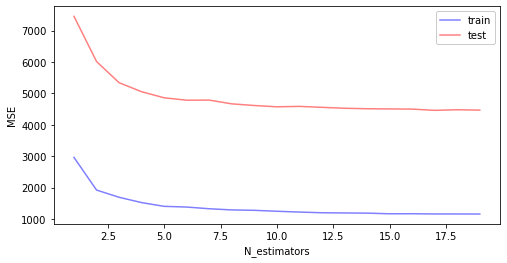

In [26]:
def rf_best_n_estimator(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        rf = RandomForestRegressor(n_estimators=i, random_state=10).fit(X_train, y_train)
        mse_train.append(mean_squared_error(np.exp(y_train), np.exp(rf.predict(X_train))))
        mse_test.append(mean_squared_error(np.exp(y_test), np.exp(rf.predict(X_test))))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("N_estimators")
    ax.legend(framealpha=1, frameon=True);

    
rf_best_n_estimator(X_train, X_test, y_train, y_test, list(range(1,20)))

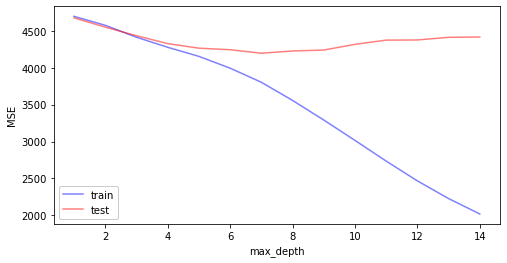

In [27]:
def rf_max_depth(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        rf = RandomForestRegressor(n_estimators=10, max_depth =i, random_state=10).fit(X_train, y_train)
        mse_train.append(mean_squared_error(np.exp(y_train), np.exp(rf.predict(X_train))))
        mse_test.append(mean_squared_error(np.exp(y_test), np.exp(rf.predict(X_test))))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("max_depth")
    ax.legend(framealpha=1, frameon=True);

    
rf_max_depth(X_train, X_test, y_train, y_test, list(range(1,15)))

In [17]:
rf = RandomForestRegressor(n_estimators = 5, max_depth = 3, random_state = 10).fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)
metrics(X_train, X_test, y_train, y_test, rf_y_pred, rf).round(2)

,MSE,RMSE,R2
Train,4429.81,66.56,0.24
Test,4442.93,66.66,0.26


In [23]:
metric_rf = metrics(X_train, X_test, y_train, y_test, rf_y_pred, rf).round(2)
metric_rf["Type"] = "Random forest"
metric_rf["city"] = "Washington, D.C."
metric_rf

,MSE,RMSE,R2,Type,city
Train,4429.81,66.56,0.24,Random forest,"Washington, D.C."
Test,4442.93,66.66,0.26,Random forest,"Washington, D.C."


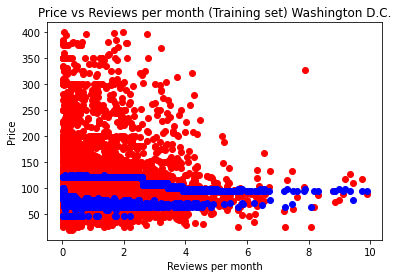

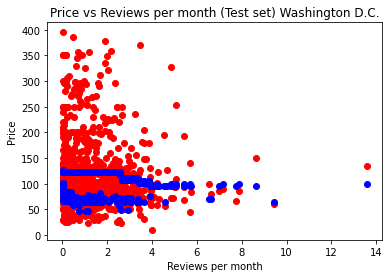

In [23]:
visualising(X_train, X_test, y_train, y_test, rf_y_pred, rf)

Text(0.5, 1.0, 'Random Forest. Feature Importance. Washington D.C.')

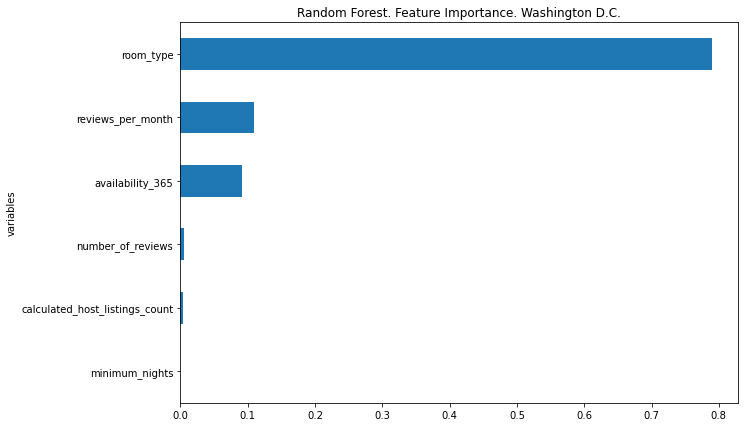

In [30]:
rf_imp = pd.DataFrame({'imp': rf.feature_importances_, 'variables': X_train.columns})
rf_imp = rf_imp.sort_values(['imp', 'variables'], ascending=[True, False]).iloc[-30:]
rf_imp.plot(kind='barh', x='variables', y='imp', figsize=(10, 7), legend=None)
#plt.title('Random Forest. Feature Importance. Washington D.C.')

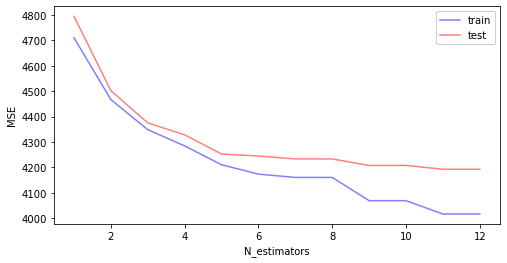

In [31]:
def catboost_best_n_estimator(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        catboost = CatBoostRegressor(iterations=i, random_state=10, eval_metric='RMSE', loss_function='RMSE').fit(X_train, y_train,
                                                                                                                 eval_set=(X_test, y_test),
                                                                                                                  logging_level='Silent')
        mse_train.append(mean_squared_error(np.exp(y_train), np.exp(catboost.predict(X_train))))
        mse_test.append(mean_squared_error(np.exp(y_test), np.exp(catboost.predict(X_test))))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("N_estimators")
    ax.legend(framealpha=1, frameon=True);

    
catboost_best_n_estimator(X_train, X_test, y_train, y_test, list(range(1,13)))



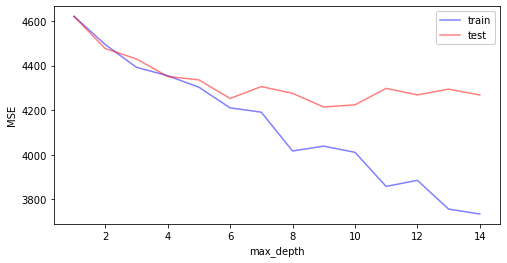

In [32]:
def catboost_max_depth(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        catboost = CatBoostRegressor(iterations=5, max_depth=i, random_state=10, eval_metric='RMSE', loss_function='RMSE').fit(X_train, y_train,
                                                                                                                 eval_set=(X_test, y_test),
                                                                                                                  logging_level='Silent')
        mse_train.append(mean_squared_error(np.exp(y_train), np.exp(catboost.predict(X_train))))
        mse_test.append(mean_squared_error(np.exp(y_test), np.exp(catboost.predict(X_test))))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("max_depth")
    ax.legend(framealpha=1, frameon=True);

    
catboost_max_depth(X_train, X_test, y_train, y_test, list(range(1,15)))

In [20]:
catboost = CatBoostRegressor(iterations=5, max_depth=6, random_state=10, eval_metric='RMSE', loss_function='RMSE').fit(X_train, y_train,
                                                                                                                 eval_set=(X_test, y_test),
                                                                                                                  logging_level='Silent')
cat_y_pred = catboost.predict(X_test)
metrics(X_train, X_test, y_train, y_test, cat_y_pred, catboost).round(2)

,MSE,RMSE,R2
Train,4210.78,64.89,0.28
Test,4252.93,65.21,0.28


In [24]:
metric_cb = metrics(X_train, X_test, y_train, y_test, cat_y_pred, catboost).round(2)
metric_cb["Type"] = "Catboost"
metric_cb["city"] = "Washington, D.C."
metric_cb

,MSE,RMSE,R2,Type,city
Train,4210.78,64.89,0.28,Catboost,"Washington, D.C."
Test,4252.93,65.21,0.28,Catboost,"Washington, D.C."


In [27]:
metric=pd.concat([metric_lr,metric_dt,metric_rf,metric_cb])
metric
metric.to_csv('Metric_DC.csv', index=True)

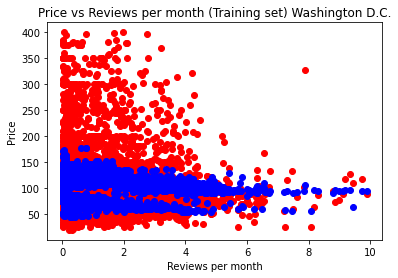

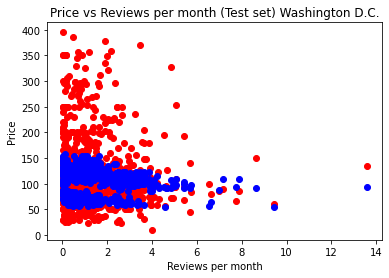

In [26]:
visualising(X_train, X_test, y_train, y_test, cat_y_pred, catboost)

Text(0.5, 1.0, 'Boosting. Feature Importance. Washington D.C.')

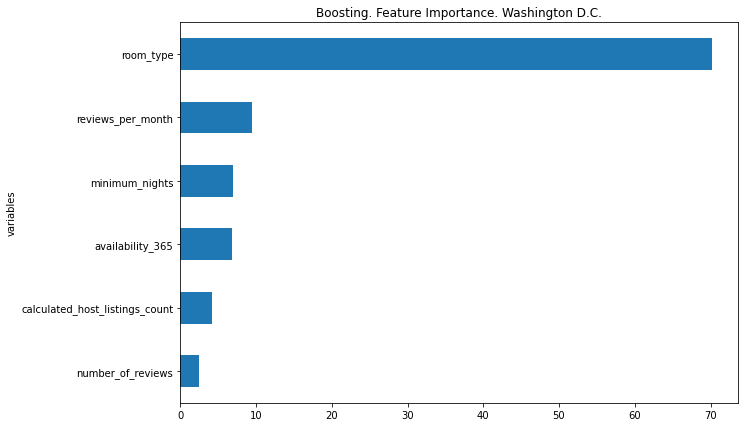

In [36]:
cb_imp = pd.DataFrame({'imp': catboost.get_feature_importance(), 'variables': X_train.columns})
cb_imp = cb_imp.sort_values(['imp', 'variables'], ascending=[True, False]).iloc[-30:]
cb_imp.plot(kind='barh', x='variables', y='imp', figsize=(10, 7), legend=None)
plt.title('Boosting. Feature Importance. Washington D.C.')

In [33]:
Spaces = collections.OrderedDict([
    ('learning_rate', hp.loguniform('learning_rate', np.log(0.001), np.log(0.05))),
    ('num_leaves', hp.choice('num_leaves', range(10, 70, 5))),
    ('num_iterations', hp.choice('num_iterations', range(1, 30, 2))),
    ('min_data_in_leaf', hp.choice('min_data_in_leaf', range(10, 100, 1))),
    ('objective', hp.choice('objective', ['regression_l1', 'regression_l1', 'mse']))
])

In [ ]:
df_apartament = df.loc[df.roo]